In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt 

In [2]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=50


IMPORT DATA INTO TENSORFLOW DATASET OBJECT

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
  "tomato_dataset",
  seed=123,
  shuffle=True,
  image_size=(IMAGE_SIZE,IMAGE_SIZE),
  batch_size=BATCH_SIZE
)

Found 4520 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [5]:
for image_batch,labels_batch in dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.numpy())

(32, 256, 256, 3)
[2 2 0 1 1 2 1 1 2 0 1 2 1 2 0 1 1 2 0 1 1 1 1 1 2 2 1 0 1 0 2 1]




As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels


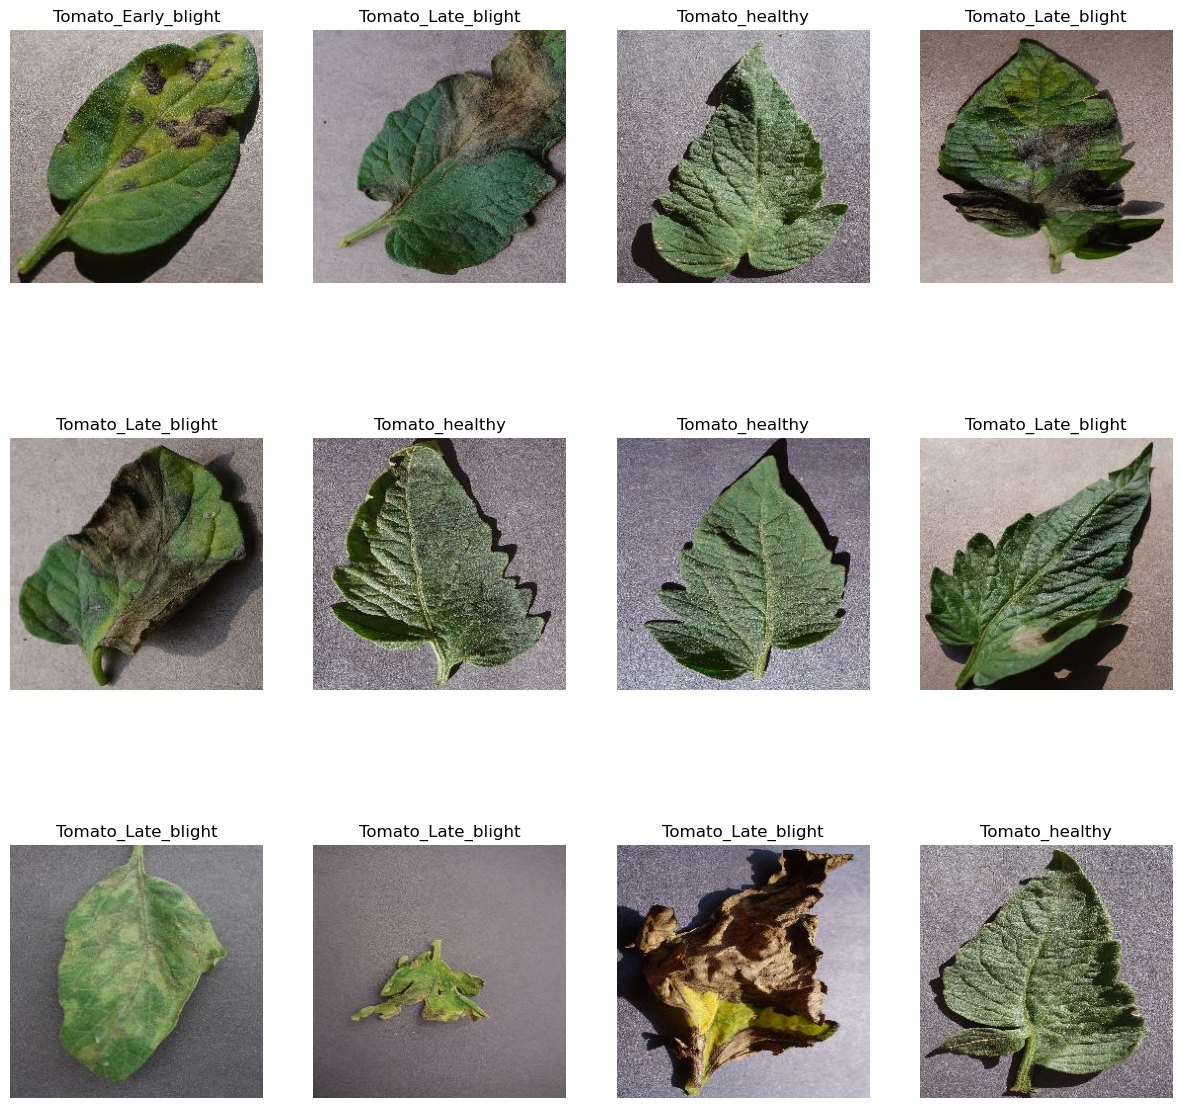

In [6]:
#visualizing some off the image from our dataset
plt.figure(figsize=(15,15))
for image_batch,labels_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1) # r,c
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")
    

#data splitting

In [7]:
len(dataset)

142

In [8]:
train_size=0.8
len(dataset)*train_size

113.60000000000001

In [9]:
train_ds=dataset.take(int(len(dataset)*train_size))
len(train_ds)

113

In [10]:
test_ds=dataset.skip(int(len(dataset)*train_size))
len(test_ds)

29

In [11]:
val_size=0.1
len(dataset)*val_size

14.200000000000001

In [12]:
val_ds = test_ds.take(14)
len(val_ds)

14

In [13]:
test_ds = test_ds.skip(14)
len(test_ds)

15

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

113

In [17]:
len(val_ds)


14

In [18]:
len(test_ds)

15

Cache , Shuffle and Prefetch the Dataset


In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=-1)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=-1)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=-1)

Building the Model
Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

we need to resize (256,256) image to again (256,256). we don't need this for training but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

Applying Data Augmentation to Train Dataset

In [23]:

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=-1)

Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. 

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         


Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric


In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
113/113 [==============================] - 70s 604ms/step - loss: 0.9095 - accuracy: 0.5360 - val_loss: 0.5589 - val_accuracy: 0.7790
Epoch 2/50
113/113 [==============================] - 65s 577ms/step - loss: 0.4730 - accuracy: 0.7904 - val_loss: 0.3970 - val_accuracy: 0.8237
Epoch 3/50
113/113 [==============================] - 68s 600ms/step - loss: 0.4177 - accuracy: 0.8211 - val_loss: 0.3782 - val_accuracy: 0.8393
Epoch 4/50
113/113 [==============================] - 88s 783ms/step - loss: 0.4997 - accuracy: 0.7898 - val_loss: 0.3602 - val_accuracy: 0.8438
Epoch 5/50
113/113 [==============================] - 78s 689ms/step - loss: 0.3787 - accuracy: 0.8421 - val_loss: 0.4503 - val_accuracy: 0.8147
Epoch 6/50
113/113 [==============================] - 86s 756ms/step - loss: 0.3801 - accuracy: 0.8382 - val_loss: 0.3719 - val_accuracy: 0.8482
Epoch 7/50
113/113 [==============================] - 85s 754ms/step - loss: 0.3645 - accuracy: 0.8537 - val_loss: 0.5586 - val_ac

In [28]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 4s 144ms/step - loss: 0.0462 - accuracy: 0.9812


In [29]:
scores

[0.046214960515499115, 0.981249988079071]



Scores is just a list containing loss and accuracy value


In [30]:
# Plotting the Accuracy and Loss Curves
history

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 113}



loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch


In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
type(history.history['loss'])

list

In [34]:
len(history.history['loss'])

50

In [35]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9094877243041992,
 0.47297734022140503,
 0.41769203543663025,
 0.49965235590934753,
 0.3787308633327484]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

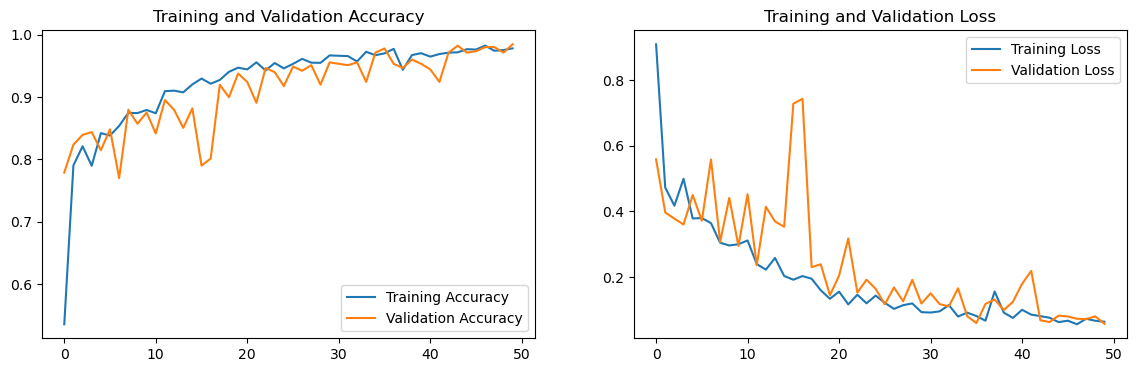

In [40]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run prediction on a sample image

first image to predict
actual label: Tomato_healthy
1/1 [==============================] - 0s 295ms/step
predicted label: Tomato_healthy


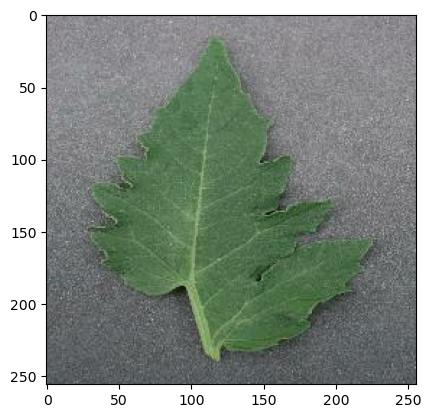

In [41]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a function for inference

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample images

1/1 [==============================] - 0s 15ms/step


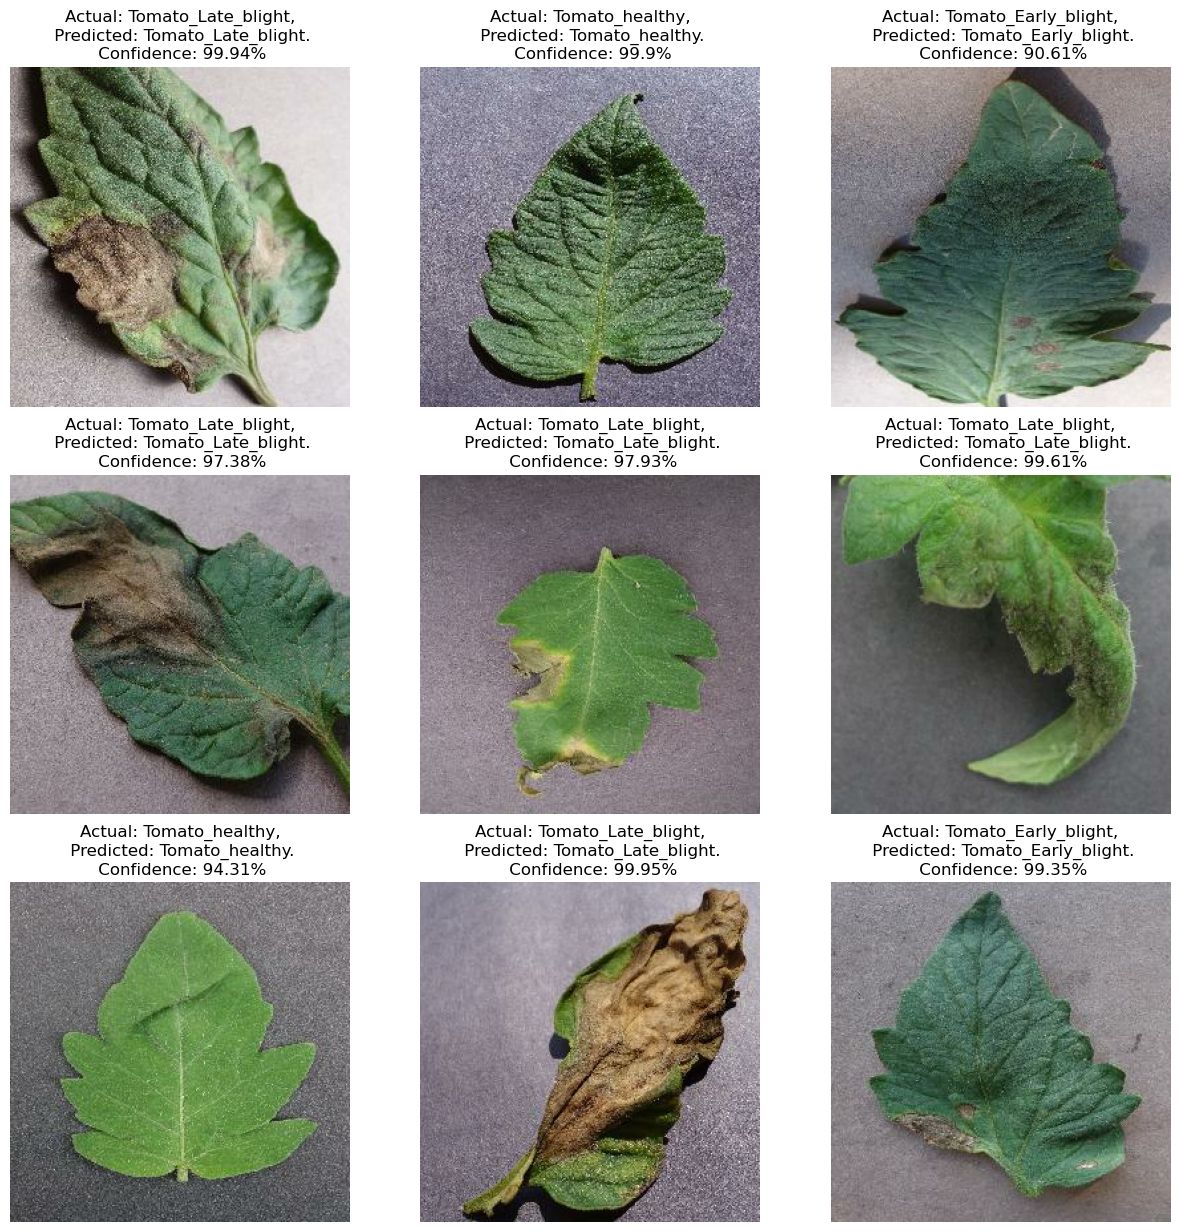

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


Saving the Model

We append the model to the list of models as a new version


In [46]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/2/assets


INFO:tensorflow:Assets written to: ../saved_models/2/assets


In [43]:
model.save("../tomatoes.h5")